# Chapter 6
`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`

`Ported to PyMC last by Kurisu Chan (@miemiekurisu)`

---

This chapter of [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) focuses on the most debated and discussed part of Bayesian methodologies: how to choose an appropriate prior distribution. We also present how the prior's influence changes as our dataset increases, and an interesting relationship between priors and penalties on linear regression.

## Getting our priorities straight


Up until now, we have mostly ignored our choice of priors. This is unfortunate as we can be very expressive with our priors, but we also must be careful about choosing them. This is especially true if we want to be objective, that is, not to express any personal beliefs in the priors. 

### Subjective vs Objective priors

Bayesian priors can be classified into two classes: *objective* priors, which aim to allow the data to influence the posterior the most, and *subjective* priors, which allow the practitioner to express his or her views into the prior. 

What is an example of an objective prior? We have seen some already, including the *flat* prior, which is a uniform distribution over the entire possible range of the unknown. Using a flat prior implies that we give each possible value an equal weighting. Choosing this type of prior is invoking what is called "The Principle of Indifference", literally we have no prior reason to favor one value over another. Calling a flat prior over a restricted space an objective prior is not correct, though it seems similar. If we know $p$ in a Binomial model is greater than 0.5, then $\text{Uniform}(0.5,1)$ is not an objective prior (since we have used prior knowledge) even though it is "flat" over [0.5, 1]. The flat prior must be flat along the *entire* range of possibilities. 

Aside from the flat prior, other examples of objective priors are less obvious, but they contain important characteristics that reflect objectivity. For now, it should be said that *rarely* is a objective prior *truly* objective. We will see this later. 

#### Subjective Priors

On the other hand, if we added more probability mass to certain areas of the prior, and less elsewhere, we are biasing our inference towards the unknowns existing in the former area. This is known as a subjective, or *informative* prior. In the figure below, the subjective prior reflects a belief that the unknown likely lives around 0.5, and not around the extremes. The objective prior is insensitive to this.

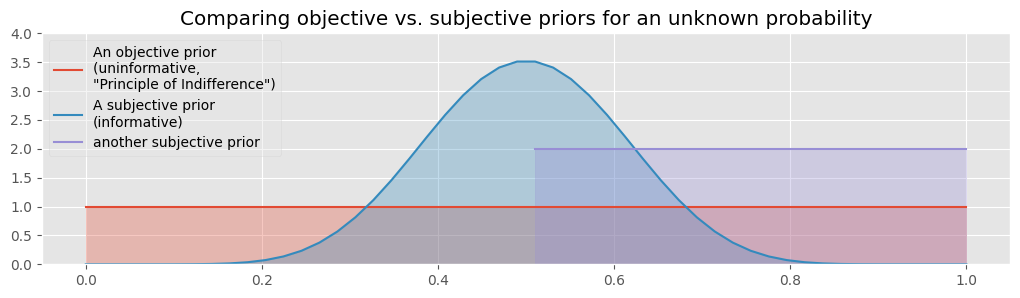

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import matplotlib as mtl
mtl.style.use("ggplot")

figsize(12.5,3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1)
y1, y2 = stats.beta.pdf(x, 1,1), stats.beta.pdf(x, 10,10)

p = plt.plot(x, y1, 
    label='An objective prior \n(uninformative, \n"Principle of Indifference")')
plt.fill_between(x, 0, y1, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x,y2 ,
     label = "A subjective prior \n(informative)")
plt.fill_between(x, 0, y2, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x[25:], 2*np.ones(25), label = "another subjective prior")
plt.fill_between(x[25:], 0, 2, color = p[0].get_color(), alpha = 0.3)

plt.ylim(0,4)

plt.ylim(0, 4)
leg = plt.legend(loc = "upper left")
leg.get_frame().set_alpha(0.4)
plt.title("Comparing objective vs. subjective priors for an unknown probability");

The choice of a subjective prior does not always imply that we are using the practitioner's subjective opinion: more often the subjective prior was once a posterior to a previous problem, and now the practitioner is updating this posterior with new data. A subjective prior can also be used to inject *domain knowledge* of the problem into the model. We will see examples of these two situations later.

### Decision, decisions...

The choice, either *objective* or *subjective* mostly depends on the problem being solved, but there are a few cases where one is preferred over the other. In instances of scientific research, the choice of an objective prior is obvious. This eliminates any biases in the results, and two researchers who might have differing prior opinions would feel an objective prior is fair. Consider a more extreme situation:

> A tobacco company publishes a report with a Bayesian methodology that retreated 60 years of medical research on tobacco use. Would you believe the results? Unlikely. The researchers probably chose a subjective prior that too strongly biased results in their favor.

Unfortunately, choosing an objective prior is not as simple as selecting a flat prior, and even today the problem is still not completely solved. The problem with naively choosing the uniform prior is that pathological issues can arise. Some of these issues are pedantic, but we delay more serious issues to the Appendix of this Chapter (TODO).

We must remember that choosing a prior, whether subjective or objective, is still part of the modeling process. To quote Gelman [5]:

>... after the model has been fit, one should look at the posterior distribution
and see if it makes sense. If the posterior distribution does not make sense, this implies
that additional prior knowledge is available that has not been included in the model,
and that contradicts the assumptions of the prior distribution that has been used. It is
then appropriate to go back and alter the prior distribution to be more consistent with
this external knowledge.

If the posterior does not make sense, then clearly one had an idea what the posterior *should* look like (not what one *hopes* it looks like), implying that the current prior does not contain all the prior information and should be updated. At this point, we can discard the current prior and choose a more reflective one.

Gelman [4] suggests that using a uniform distribution with large bounds is often a good choice for objective priors. Although, one should be wary about using Uniform objective priors with large bounds, as they can assign too large of a prior probability to non-intuitive points. Ask yourself: do you really think the unknown could be incredibly large? Often quantities are naturally biased towards 0. A Normal random variable with large variance (small precision) might be a better choice, or an Exponential with a fat tail in the strictly positive (or negative) case. 

If using a particularly subjective prior, it is your responsibility to be able to explain the choice of that prior, else you are no better than the tobacco company's guilty parties. 

### Empirical Bayes

While not a true Bayesian method, *empirical Bayes* is a trick that combines frequentist and Bayesian inference. As mentioned previously, for (almost) every inference problem there is a Bayesian method and a frequentist method. The significant difference between the two is that Bayesian methods have a prior distribution, with hyperparameters $\alpha$, while empirical methods do not have any notion of a prior. Empirical Bayes combines the two methods by using frequentist methods to select $\alpha$, and then proceeds with Bayesian methods on the original problem. 

A very simple example follows: suppose we wish to estimate the parameter $\mu$ of a Normal distribution, with $\sigma = 5$. Since $\mu$ could range over the whole real line, we can use a Normal distribution as a prior for $\mu$. How to select the prior's hyperparameters, denoted ($\mu_p, \sigma_p^2$)? The $\sigma_p^2$ parameter can be chosen to reflect the uncertainty we have. For $\mu_p$, we have two options:

1. Empirical Bayes suggests using the empirical sample mean, which will center the prior around the observed empirical mean:

$$ \mu_p = \frac{1}{N} \sum_{i=0}^N X_i $$

2. Traditional Bayesian inference suggests using prior knowledge, or a more objective prior (zero mean and fat standard deviation).

Empirical Bayes can be argued as being semi-objective, since while the choice of prior model is ours (hence subjective), the parameters are solely determined by the data.

Personally, I feel that Empirical Bayes is *double-counting* the data. That is, we are using the data twice: once in the prior, which will influence our results towards the observed data, and again in the inferential engine of MCMC. This double-counting will understate our true uncertainty. To minimize this double-counting, I would only suggest using Empirical Bayes when you have *lots* of observations, else the prior will have too strong of an influence. I would also recommend, if possible, to maintain high uncertainty (either by setting a large $\sigma_p^2$ or equivalent.)

Empirical Bayes also violates a theoretical axiom in Bayesian inference. The textbook Bayesian algorithm of:

>*prior* $\Rightarrow$ *observed data* $\Rightarrow$ *posterior* 

is violated by Empirical Bayes, which instead uses 

>*observed data* $\Rightarrow$ *prior* $\Rightarrow$ *observed data* $\Rightarrow$ *posterior*

Ideally, all priors should be specified *before* we observe the data, so that the data does not influence our prior opinions (see the volumes of research by Daniel Kahneman *et. al* about [anchoring](http://en.wikipedia.org/wiki/Anchoring_and_adjustment)).

## Useful priors to know about

### The Gamma distribution

A Gamma random variable, denoted $X \sim \text{Gamma}(\alpha, \beta)$, is a random variable over the positive real numbers. It is in fact a generalization of the Exponential random variable, that is:

$$ \text{Exp}(\beta) \sim \text{Gamma}(1, \beta) $$

This additional parameter allows the probability density function to have more flexibility, hence allowing the practitioner to express his or her subjective priors more accurately. The density function for a $\text{Gamma}(\alpha, \beta)$ random variable is:

$$ f(x \mid \alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)} $$

where $\Gamma(\alpha)$ is the [Gamma function](http://en.wikipedia.org/wiki/Gamma_function), and for differing values of $(\alpha, \beta)$ looks like:

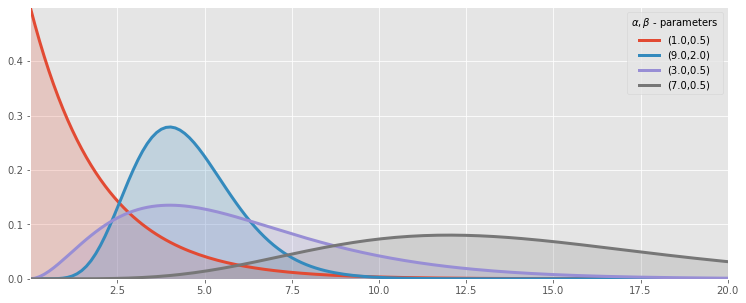

In [2]:
figsize(12.5, 5)
gamma = stats.gamma

parameters = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]
x = np.linspace(0.001 ,20, 150)
for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale=1./beta)
    lines = plt.plot(x, y, label = "(%.1f,%.1f)"%(alpha,beta), lw = 3)
    plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title=r"$\alpha, \beta$ - parameters");

### The Wishart distribution

Until now, we have only seen random variables that are scalars. Of course, we can also have *random matrices*! Specifically, the Wishart distribution is a distribution over all [positive semi-definite matrices](http://en.wikipedia.org/wiki/Positive-definite_matrix). Why is this useful to have in our arsenal? (Proper) covariance matrices are positive-definite, hence the Wishart is an appropriate prior for covariance matrices. We can't really visualize a distribution of matrices, so I'll plot some realizations from the $5 \times 5$ (above) and $20 \times 20$ (below) Wishart distribution:

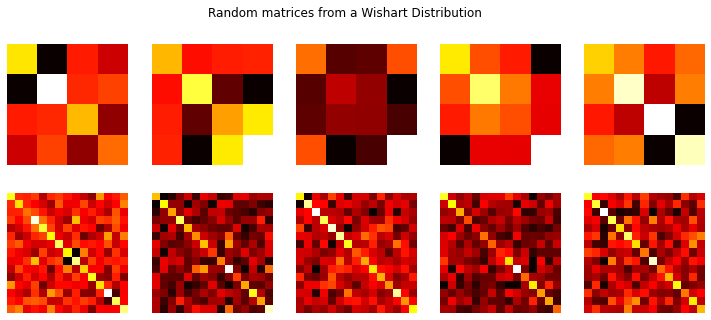

In [3]:

n = 4
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    if i >= 5:
        n = 15
    plt.imshow(stats.wishart.rvs(n+1, np.eye(n)), interpolation="none", 
                cmap = "hot")
    ax.axis("off")
    
plt.suptitle("Random matrices from a Wishart Distribution");

One thing to notice is the symmetry of these matrices. The Wishart distribution can be a little troubling to deal with, but we will use it in an example later.

### The Beta distribution

You may have seen the term `beta` in previous code in this book. Often, I was implementing a Beta distribution. The Beta distribution is very useful in Bayesian statistics. A random variable $X$ has a $\text{Beta}$ distribution, with parameters $(\alpha, \beta)$, if its density function is:

$$f_X(x | \; \alpha, \beta ) = \frac{ x^{(\alpha - 1)}(1-x)^{ (\beta - 1) } }{B(\alpha, \beta) }$$

where $B$ is the [Beta function](http://en.wikipedia.org/wiki/Beta_function) (hence the name). The random variable $X$ is only allowed in [0,1], making the Beta distribution a popular distribution for decimal values, probabilities and proportions. The values of $\alpha$ and $\beta$, both positive values, provide great flexibility in the shape of the distribution. Below we plot some distributions:

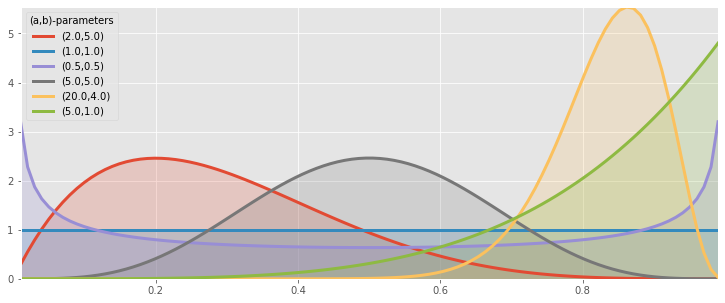

In [4]:
figsize(12.5, 5)

params = [(2, 5), (1, 1), (0.5, 0.5), (5, 5), (20, 4), (5, 1)]

x = np.linspace(0.01, .99, 100)
beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines = plt.plot(x, y, label = "(%.1f,%.1f)"%(a,b), lw = 3)
    plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
    plt.autoscale(tight=True)
plt.ylim(0)
plt.legend(loc = 'upper left', title="(a,b)-parameters");

One thing I'd like the reader to notice is the presence of the flat distribution above, specified by parameters $(1,1)$. This is the Uniform distribution. Hence the Beta distribution is a generalization of the Uniform distribution, something we will revisit many times.

There is an interesting connection between the Beta distribution and the Binomial distribution. Suppose we are interested in some unknown proportion or probability $p$. We assign a $\text{Beta}(\alpha, \beta)$ prior to $p$. We observe some data generated by a Binomial process, say $X \sim \text{Binomial}(N, p)$, with $p$ still unknown. Then our posterior *is again a Beta distribution*, i.e. $p | X \sim \text{Beta}( \alpha + X, \beta + N -X )$. Succinctly, one can relate the two by "a Beta prior with Binomial observations creates a Beta posterior". This is a very useful property, both computationally and heuristically.

In light of the above two paragraphs, if we start with a $\text{Beta}(1,1)$ prior on $p$ (which is a Uniform), observe data $X \sim \text{Binomial}(N, p)$, then our posterior is $\text{Beta}(1 + X, 1 + N - X)$. 


##### Example: Bayesian Multi-Armed Bandits
*Adapted from an example by Ted Dunning of MapR Technologies*

> Suppose you are faced with $N$ slot machines (colourfully called multi-armed bandits). Each bandit has an unknown probability of distributing a prize (assume for now the prizes are the same for each bandit, only the probabilities differ). Some bandits are very generous, others not so much. Of course, you don't know what these probabilities are. By only choosing one bandit per round, our task is devise a strategy to maximize our winnings.

Of course, if we knew the bandit with the largest probability, then always picking this bandit would yield the maximum winnings. So our task can be phrased as "Find the best bandit, and as quickly as possible". 

The task is complicated by the stochastic nature of the bandits. A suboptimal bandit can return many winnings, purely by chance, which would make us believe that it is a very profitable bandit. Similarly, the best bandit can return many duds. Should we keep trying losers then, or give up? 

A more troublesome problem is, if we have found a bandit that returns *pretty good* results, do we keep drawing from it to maintain our *pretty good score*, or do we try other bandits in hopes of finding an *even-better* bandit? This is the exploration vs. exploitation dilemma.

### Applications


The Multi-Armed Bandit problem at first seems very artificial, something only a mathematician would love, but that is only before we address some applications:

- Internet display advertising: companies have a suite of potential ads they can display to visitors, but the company is not sure which ad strategy to follow to maximize sales. This is similar to A/B testing, but has the added advantage of naturally minimizing strategies that do not work (and generalizes to A/B/C/D... strategies)
- Ecology: animals have a finite amount of energy to expend, and following certain behaviours has uncertain rewards. How does the animal maximize its fitness?
- Finance: which stock option gives the highest return, under time-varying return profiles.
- Clinical trials: a researcher would like to find the best treatment, out of many possible treatment, while minimizing losses. 
- Psychology: how does punishment and reward affect our behaviour? How do humans learn?

Many of these questions above are fundamental to the application's field.

It turns out the *optimal solution* is incredibly difficult, and it took decades for an overall solution to develop. There are also many approximately-optimal solutions which are quite good. The one I wish to discuss is one of the few solutions that can scale incredibly well. The solution is known as *Bayesian Bandits*.


### A Proposed Solution


Any proposed strategy is called an *online algorithm* (not in the internet sense, but in the continuously-being-updated sense), and more specifically a reinforcement learning algorithm. The algorithm starts in an ignorant state, where it knows nothing, and begins to acquire data by testing the system. As it acquires data and results, it learns what the best and worst behaviours are (in this case, it learns which bandit is the best). With this in mind, perhaps we can add an additional application of the Multi-Armed Bandit problem:

- Psychology: how does punishment and reward affect our behaviour? How do humans learn?


The Bayesian solution begins by assuming priors on the probability of winning for each bandit. In our vignette we assumed complete ignorance of these probabilities. So a very natural prior is the flat prior over 0 to 1. The algorithm proceeds as follows:

For each round:

1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
2. Select the bandit with largest sample, i.e. select $B = \text{argmax}\;\; X_b$.
3. Observe the result of pulling bandit $B$, and update your prior on bandit $B$.
4. Return to 1.

That's it. Computationally, the algorithm involves sampling from $N$ distributions. Since the initial priors are $\text{Beta}(\alpha=1,\beta=1)$ (a uniform distribution), and the observed result $X$ (a win or loss, encoded 1 and 0 respectfully) is Binomial, the posterior is a $\text{Beta}(\alpha=1+X,\beta=1+1−X)$.

To answer our question from before, this algorithm suggests that we should not discard losers, but we should pick them at a decreasing rate as we gather confidence that there exist *better* bandits. This follows because there is always a non-zero chance that a loser will achieve the status of $B$, but the probability of this event decreases as we play more rounds (see figure below).

Below we implement Bayesian Bandits using two classes, `Bandits` that defines the slot machines, and `BayesianStrategy` which implements the above learning strategy.

In [3]:
rand = np.random.rand

class Bandits(object):
    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):
        #i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

    
class BayesianStrategy(object):
    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """
    
    def __init__(self, bandits):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    
    def sample_bandits(self, n=1):
        
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from the bandits's priors, and select the largest sample
            choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))
            
            #sample the chosen bandit
            result = self.bandits.pull(choice)
            
            #update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result 
            self.N += 1
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return 

Below we visualize the learning of the Bayesian Bandit solution.

In [4]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha, 
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

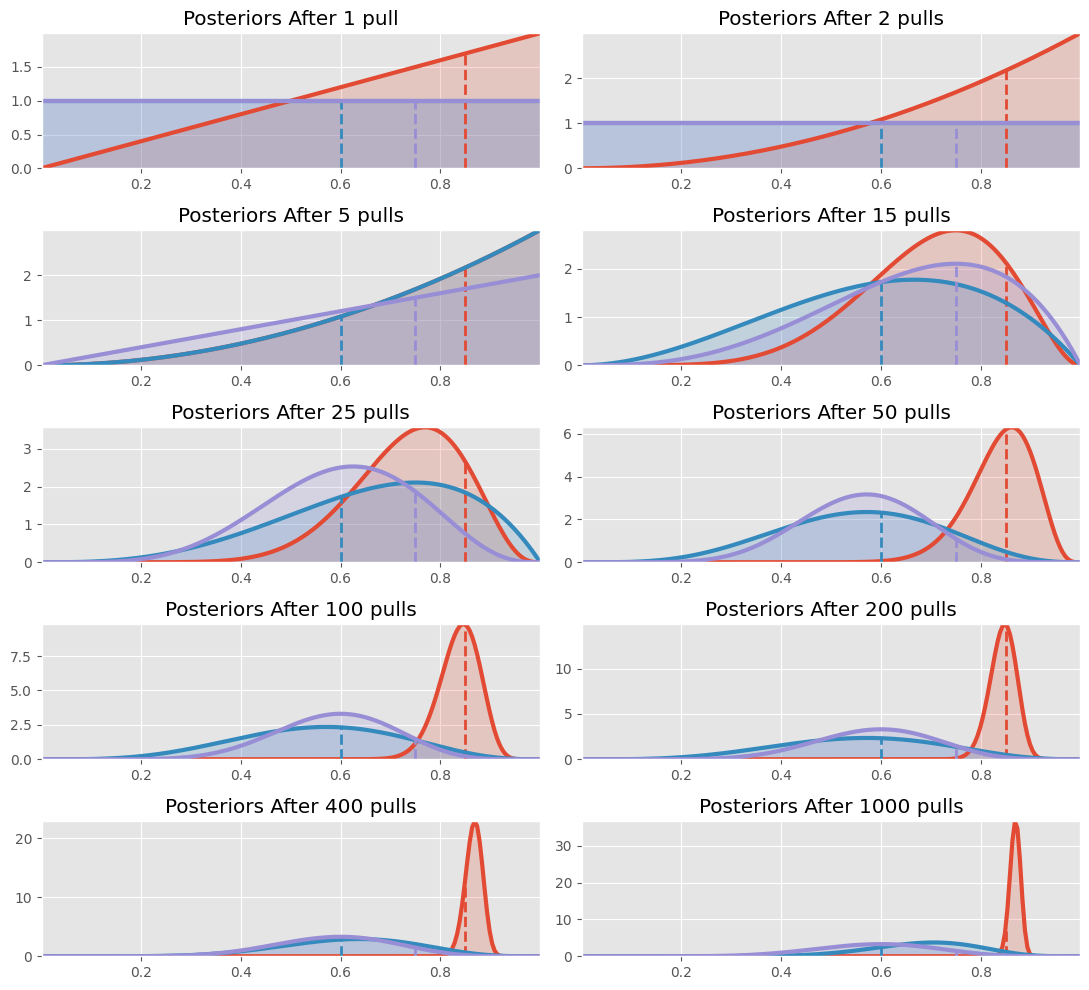

In [14]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    #plt.legend()
    plt.autoscale(tight = True)
plt.tight_layout()

Note that we don't really care how accurate we become about the inference of the hidden probabilities &mdash; for this problem we are more interested in choosing the best bandit (or more accurately, becoming *more confident* in choosing the best bandit). For this reason, the distribution of the red bandit is very wide (representing ignorance about what that hidden probability might be) but we are reasonably confident that it is not the best, so the algorithm chooses to ignore it.

From the above, we can see that after 1000 pulls, the majority of the "blue" function leads the pack, hence we will almost always choose this arm. This is good, as this arm is indeed the best.

Below is a D3 app that demonstrates our algorithm updating/learning three bandits.  The first figure are the raw counts of pulls and wins, and the second figure is a dynamically updating plot. I encourage you to try to guess which bandit is optimal, prior to revealing the true probabilities, by selecting the `arm buttons`.

In [13]:
from IPython.core.display import HTML

#try executing the below command twice if the first time doesn't work
HTML(filename = "BanditsD3.html")

Deviations of the observed ratio from the highest probability is a measure of performance. For example,in the long run, optimally we can attain the reward/pull ratio of the maximum bandit probability. Long-term realized ratios less than the maximum represent inefficiencies. (Realized ratios larger than the maximum probability is due to randomness, and will eventually fall below). 

### A Measure of *Good*

We need a metric to calculate how well we are doing. Recall the absolute *best* we can do is to always pick the bandit with the largest probability of winning. Denote this best bandit's probability by $w_{opt}$. Our score should be relative to how well we would have done had we chosen the best bandit from the beginning. This motivates the *total regret* of a strategy, defined:

\begin{align}
R_T & = \sum_{i=1}^{T} \left( w_{opt} - w_{B(i)} \right)\\\\
& = Tw^* - \sum_{i=1}^{T} \;  w_{B(i)} 
\end{align}


where $w_{B(i)}$ is the probability of a prize of the chosen bandit in the $i$ round. A total regret of 0 means the strategy is matching the best possible score. This is likely not possible, as initially our algorithm will often make the wrong choice.  Ideally, a strategy's total regret should flatten as it learns the best bandit. (Mathematically, we achieve $w_{B(i)}=w_{opt}$ often)


Below we plot the total regret of this simulation, including the scores of some other strategies:

1. Random: randomly choose a bandit to pull. If you can't beat this, just stop. 
2. Largest Bayesian credible bound: pick the bandit with the largest upper bound in its 95% credible region of the underlying probability. 
3. Bayes-UCB algorithm: pick the bandit with the largest *score*, where score is a dynamic quantile of the posterior (see [4] )
3. Mean of posterior: choose the bandit with the largest posterior mean. This is what a human player (sans computer) would likely do. 
3. Largest proportion: pick the bandit with the current largest observed proportion of winning. 

The code for these are in the `other_strats.py`, where you can implement your own very easily.

In [15]:
figsize(12.5, 5)
from other_strats import *

#define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

#define regret
def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

#create new strategies
strategies= [upper_credible_choice, 
            bayesian_bandit_choice, 
            ucb_bayes , 
            max_mean,
            random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

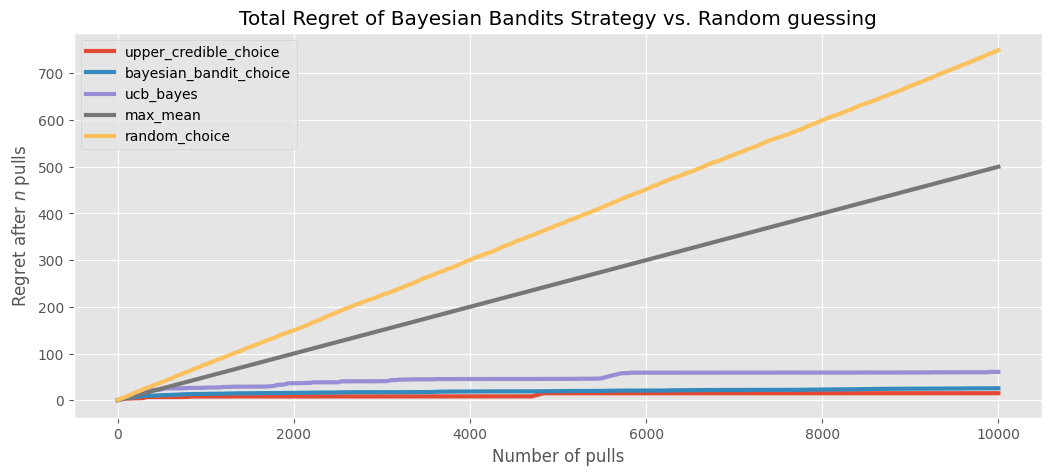

In [16]:
#train 10000 times
for strat in algos:
    strat.sample_bandits(10000)
    
#test and plot
for i,strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label = strategies[i].__name__, lw = 3)

plt.title("Total Regret of Bayesian Bandits Strategy vs. Random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc = "upper left");

Like we wanted, Bayesian bandits and other strategies have decreasing rates of regret, representing we are achieving optimal choices. To be more scientific so as to remove any possible luck in the above simulation, we should instead look at the *expected total regret*:

$$\bar{R}_T = E[ R_T ] $$

It can be shown that any *sub-optimal* strategy's expected total regret is bounded below logarithmically. Formally,

$$ E[R_T] = \Omega \left( \;\log(T)\; \right) $$

Thus, any strategy that matches logarithmic-growing regret is said to "solve" the Multi-Armed Bandit problem [3].

Using the Law of Large Numbers, we can approximate Bayesian Bandit's expected total regret by performing the same experiment many times (500 times, to be fair):

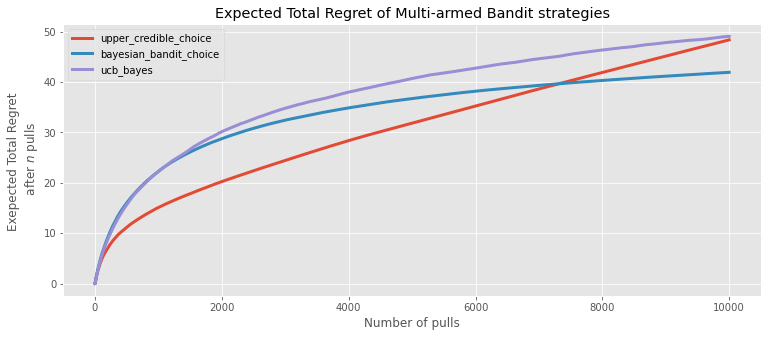

In [11]:
#this can be slow, so I recommend NOT running it. 

trials = 500
expected_total_regret = np.zeros((10000, 3))

for i_strat, strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(10000)
        _regret =  regret(hidden_prob, general_strat.choices)
        expected_total_regret[:,i_strat] += _regret
    plt.plot(expected_total_regret[:,i_strat]/trials, lw =3, label = strat.__name__)
        
plt.title("Expected Total Regret of Multi-armed Bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Exepected Total Regret \n after $n$ pulls");
plt.legend(loc = "upper left");

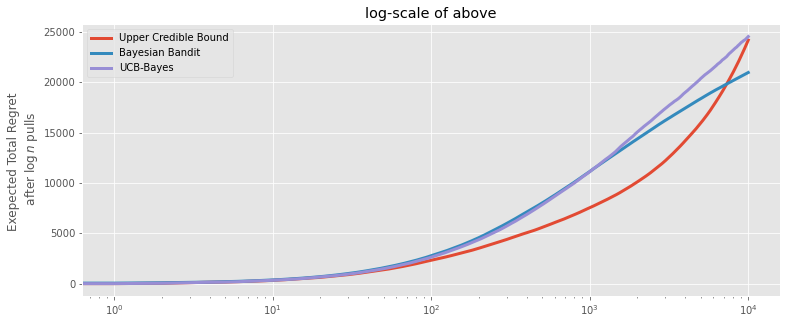

In [12]:
plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0,1,2]], lw = 3)
plt.xscale("log")
plt.legend([pl1, pl2, pl3], 
           ["Upper Credible Bound", "Bayesian Bandit", "UCB-Bayes"],
            loc="upper left")
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");
plt.title( "log-scale of above" );
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");

### Extending the algorithm 


Because of the Bayesian Bandits algorithm's simplicity, it is easy to extend. Some possibilities:

- If interested in the *minimum* probability (eg: where prizes are a bad thing), simply choose $B = \text{argmin} \; X_b$ and proceed.

- Adding learning rates: Suppose the underlying environment may change over time. Technically the standard Bayesian Bandit algorithm would self-update itself (awesome) by noting that what it thought was the best is starting to fail more often. We can motivate the algorithm to learn changing environments quicker by simply adding a *rate* term upon updating:

        self.wins[choice] = rate*self.wins[choice] + result
        self.trials[choice] = rate*self.trials[choice] + 1

   If `rate < 1`, the algorithm will *forget* its previous wins quicker and there will be a downward  pressure towards ignorance. Conversely, setting `rate > 1` implies your algorithm will act more risky, and bet on earlier winners more often and be more resistant to changing environments. 

- Hierarchical algorithms: We can setup a Bayesian Bandit algorithm on top of smaller bandit algorithms. Suppose we have $N$ Bayesian Bandit models, each varying in some behavior (for example  different `rate` parameters, representing varying sensitivity to changing environments). On top of these $N$ models is another Bayesian Bandit learner that will select a sub-Bayesian Bandit. This chosen Bayesian Bandit will then make an internal choice as to which machine to pull. The super-Bayesian Bandit updates itself depending on whether the sub-Bayesian Bandit was correct or not. 

- Extending the rewards, denoted $y_a$ for bandit $a$, to random variables from a distribution $f_{y_a}(y)$ is straightforward. More generally, this problem can be rephrased as "Find the bandit with the largest expected value", as playing the bandit with the largest expected value is optimal. In the case above, $f_{y_a}$ was Bernoulli with probability $p_a$, hence the expected value for a bandit is equal to $p_a$, which is why it looks like we are aiming to maximize the probability of winning. If $f$ is not Bernoulli, and it is non-negative, which can be accomplished apriori by shifting the distribution (we assume we know $f$), then the algorithm behaves as before:

   For each round, 
    
   1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
   2. Select the bandit with largest sample, i.e. select bandit $B = \text{argmax}\;\; X_b$.
   3. Observe the result,$R \sim f_{y_a}$, of pulling bandit $B$, and update your prior on bandit $B$.
   4. Return to 1

   The issue is in the sampling of $X_b$ drawing phase. With Beta priors and Bernoulli observations, we have a Beta posterior &mdash; this is easy to sample from. But now, with arbitrary distributions $f$, we have a non-trivial posterior. Sampling from these can be difficult.

- There has been some interest in extending the Bayesian Bandit algorithm to commenting systems. Recall in Chapter 4, we developed a ranking algorithm based on the Bayesian lower-bound of the proportion of upvotes to total votes. One problem with this approach is that it will bias the top rankings towards older comments, since older comments naturally have more votes (and hence the lower-bound is tighter to the true proportion). This creates a positive feedback cycle where older comments gain more votes, hence are displayed more often, hence gain more votes, etc. This pushes any new, potentially better comments, towards the bottom. J. Neufeld proposes a system to remedy this that uses a Bayesian Bandit solution.

His proposal is to consider each comment as a Bandit, with the number of pulls equal to the number of votes cast, and number of rewards as the number of upvotes, hence creating a $\text{Beta}(1+U,1+D)$ posterior. As visitors visit the page, samples are drawn from each bandit/comment, but instead of displaying the comment with the $\max$ sample, the comments are ranked according to the ranking of their respective samples. From J. Neufeld's blog [7]:

   > [The] resulting ranking algorithm is quite straightforward, each new time the comments page is loaded, the score for each comment is sampled from a $\text{Beta}(1+U,1+D)$, comments are then ranked by this score in descending order... This randomization has a unique benefit in that even untouched comments $(U=1,D=0)$ have some chance of being seen even in threads with 5000+ comments (something that is not happening now), but, at the same time, the user is not likely to be inundated with rating these new comments. 

Just for fun, though the colors explode, we watch the Bayesian Bandit algorithm learn 15 different options. 

[0.08531221 0.08486677 0.01339421 0.08425039 0.16465015 0.11823683
 0.01041407 0.21605291 0.00686275 0.05193728 0.07003065 0.1081212
 0.15580337 0.0979762  0.04510847 0.05186906 0.1720822  0.00723625
 0.0720327  0.17768833 0.04378006 0.04562437 0.17600121 0.10633625
 0.08907945 0.20450195 0.10479179 0.06222466 0.03928463 0.01514828
 0.02085918 0.01454992 0.07838642 0.24939638 0.01175889]


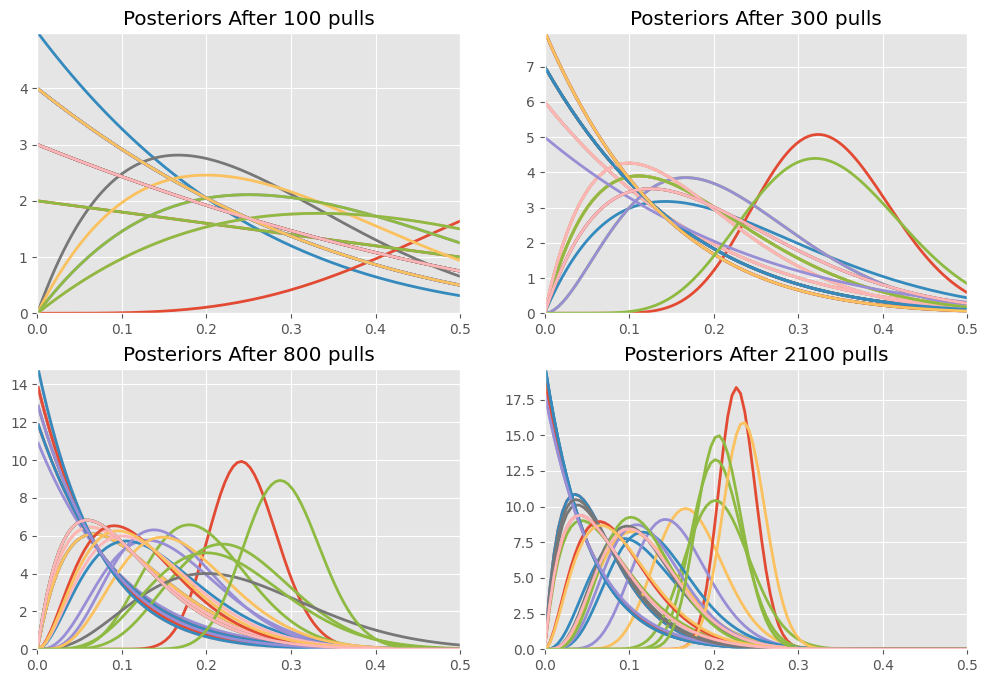

In [17]:
figsize(12.0, 8)
beta = stats.beta
hidden_prob = beta.rvs(1,13, size = 35)
print(hidden_prob)
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

for j,i in enumerate([100, 200, 500, 1300]):
    plt.subplot(2, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw = 2, alpha = 0.0, plt_vlines=False)
    #plt.legend()
    plt.xlim(0, 0.5)


## Eliciting expert prior

Specifying a subjective prior is how practitioners incorporate domain knowledge about the problem into our mathematical framework. Allowing domain knowledge is useful for many reasons:

- Aids speeds of MCMC convergence. For example, if we know the unknown parameter is strictly positive, then we can restrict our attention there, hence saving time that would otherwise be spent exploring negative values.
- More accurate inference. By weighing prior values near the true unknown value higher, we are narrowing our eventual inference (by making the posterior tighter around the unknown) 
- Express our uncertainty better. See the *Price is Right* problem in Chapter 5.

plus many other reasons. Of course, practitioners of Bayesian methods are not experts in every field, so we must turn to domain experts to craft our priors. We must be careful with how we elicit these priors though. Some things to consider:

1. From experience, I would avoid introducing Betas, Gammas, etc. to non-Bayesian practitioners. Furthermore, non-statisticians can get tripped up by how a continuous probability function can have a value exceeding one.

2. Individuals often neglect the rare *tail-events* and put too much weight around the mean of distribution. 

3. Related to above is that almost always individuals will under-emphasize the uncertainty in their guesses.

Eliciting priors from non-technical experts is especially difficult. Rather than introduce the notion of probability distributions, priors, etc. that may scare an expert, there is a much simpler solution. 

### Trial roulette method 


The *trial roulette method* [8] focuses on building a prior distribution by placing counters (think casino chips) on what the expert thinks are possible outcomes. The expert is given $N$ counters (say $N=20$) and is asked to place them on a pre-printed grid, with bins representing intervals.  Each column would represent their belief of the probability of getting the corresponding bin result. Each chip would represent an $\frac{1}{N} = 0.05$ increase in the probability of the outcome being in that interval. For example [9]:

> A student is asked to predict the mark in a future exam. The figure below shows a completed grid for the elicitation of a subjective probability distribution. The horizontal axis of the grid shows the possible bins (or mark intervals) that the student was asked to consider. The numbers in top row record the number of chips per bin. The completed grid (using a total of 20 chips) shows that the student believes there is a 30% chance that the mark will be between 60 and 64.9.


<img style="margin: auto" src="http://img641.imageshack.us/img641/4716/chipsbinscrisp.png" />

From this, we can fit a distribution that captures the expert's choice. Some reasons in favor of using this technique are:

1. Many questions about the shape of the expert's subjective probability distribution can be answered without the need to pose a long series of questions to the expert - the statistician can simply read off density above or below any given point, or that between any two points.

2. During the elicitation process, the experts can move around the chips if unsatisfied with the way they placed them initially - thus they can be sure of the final result to be submitted.

3. It forces the expert to be coherent in the set of probabilities that are provided. If all the chips are used, the probabilities must sum to one.

4. Graphical methods seem to provide more accurate results, especially for participants with modest levels of statistical sophistication.

##### Example: Stock Returns


Take note stock brokers: you're doing it wrong. When choosing which stocks to pick, an analyst will often look at the *daily return* of the stock. Suppose $S_t$ is the price of the stock on day $t$, then the daily return on day $t$ is :

$$r_t = \frac{ S_t - S_{t-1} }{ S_{t-1} } $$

The *expected daily return* of a stock is denoted $\mu = E[ r_t ]$. Obviously, stocks with high expected returns are desirable. Unfortunately, stock returns are so filled with noise that it is very hard to estimate this parameter. Furthermore, the parameter might change over time (consider the rises and falls of AAPL stock), hence it is unwise to use a large historical dataset. 

Historically, the expected return has been estimated by using the sample mean. This is a bad idea. As mentioned, the sample mean of a small sized dataset has enormous potential to be very wrong (again, see Chapter 4 for full details). Thus Bayesian inference is the correct procedure here, since we are able to see our uncertainty along with probable values.

For this exercise, we will be examining the daily returns of the AAPL, GOOG, MSFT and AMZN. Before we pull in the data, suppose we ask our a stock fund manager (an expert in finance, but see [10] ), 

> What do you think the return profile looks like for each of these companies?

Our stock broker, without needing to know the language of Normal distributions, or priors, or variances, etc. creates four distributions using the trial roulette method above. Suppose they look enough like Normals, so we fit Normals to them. They may look like: 

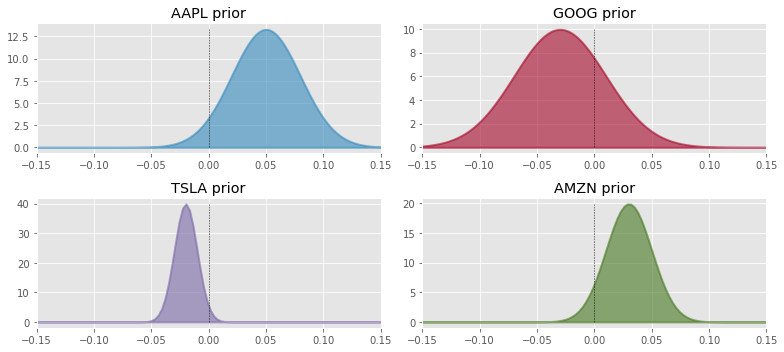

In [14]:
figsize(11., 5)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

normal = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {"AAPL":(0.05, 0.03),
                 "GOOG":(-0.03, 0.04), 
                 "TSLA": (-0.02, 0.01), 
                 "AMZN": (0.03, 0.02), 
                 }

for i, (name, params) in enumerate(expert_prior_params.items()):
    plt.subplot(2, 2, i+1)
    y = normal.pdf(x, params[0], scale = params[1])
    #plt.plot( x, y, c = colors[i] )
    plt.fill_between(x, 0, y, color = colors[i], linewidth=2,
                     edgecolor = colors[i], alpha = 0.6)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k","--", linewidth = 0.5)
    plt.xlim(-0.15, 0.15)
plt.tight_layout()

Note that these are subjective priors: the expert has a personal opinion on the stock returns of each of these companies, and is expressing them in a distribution. He's not wishful thinking -- he's introducing domain knowledge.

In order to better model these returns, we should investigate the *covariance matrix* of the returns. For example, it would be unwise to invest in two stocks that are highly correlated, since they are likely to tank together (hence why fund managers suggest a diversification strategy). We will use the *Wishart distribution* for this, introduced earlier.

Let's get some historical data for these stocks. We will use the covariance of the returns as a starting point for our Wishart random variable. This is not empirical bayes (as we will go over later) because we are only deciding the starting point, not influencing the parameters.

In [16]:
# I wish I could have used Pandas as a prereq for this book, but oh well.
import datetime
import collections
#import ystockquote as ysq
import pandas as pd
import pandas_datareader as pdr

n_observations = 100 # we will truncate the the most recent 100 days.

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]

enddate = "2015-04-27"
startdate = "2012-09-01"

CLOSE = 6

stock_closes = pd.DataFrame()

for stock in stocks:
    data = pdr.get_data_yahoo(stock,start=startdate,end=enddate)["Close"]
    #x = np.array(ysq.get_historical_prices(stock, startdate, enddate))
    #stock_series = pd.Series(x[1:,CLOSE].astype(float), name=stock)
    stock_closes[stock] = data

stock_closes = stock_closes[::-1]
stock_returns = stock_closes.pct_change()[1:][-n_observations:]
    
#dates = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), x[1:n_observations+1,0]))
dates = stock_returns.index.to_list()

And here let's form our basic model:

In [17]:
import pymc as pm
import pytensor.tensor as pt
from pytensor.tensor.nlinalg import matrix_inverse, matrix_dot
from pytensor.tensor.basic import diag
prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

init = stock_returns.cov()

with pm.Model() as model:
    cov_matrix = pm.WishartBartlett("covariance", np.diag(prior_std**2), 10, initval = init)

    mu = pm.Normal("returns", mu=prior_mu, sigma=1, shape=4)

Added new variable covariance_c to model diagonal of Wishart.
Added new variable covariance_z to model off-diagonals of Wishart.


Here are the returns for our chosen stocks:

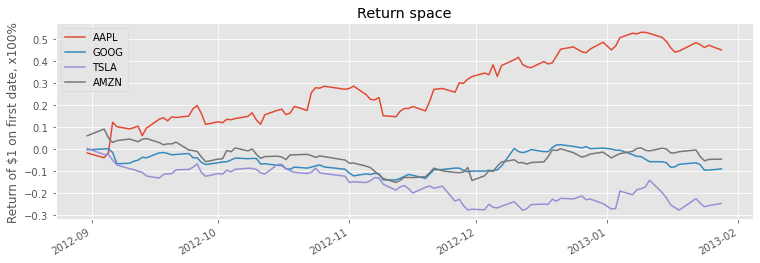

In [18]:
figsize(12.5, 4)

cum_returns = np.cumprod(1 + stock_returns) - 1
cum_returns.index = dates[::-1]
cum_returns.plot()

plt.legend(loc = "upper left")
plt.title("Return space")
plt.ylabel("Return of $1 on first date, x100%");

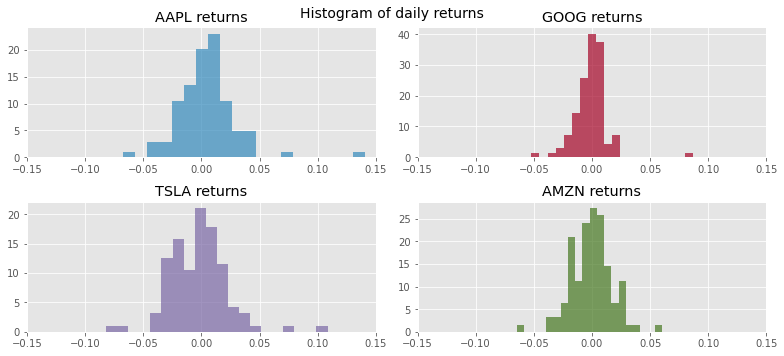

In [19]:
figsize(11., 5 )

for i, _stock in enumerate(stocks):
    plt.subplot(2,2,i+1)
    plt.hist(stock_returns[_stock], bins=20,
             density = True, histtype="stepfilled",
             color=colors[i], alpha=0.7)
    plt.title(_stock + " returns")
    plt.xlim(-0.15, 0.15)

plt.tight_layout()
plt.suptitle("Histogram of daily returns", size =14);

Below we perform the inference on the posterior mean return and posterior covariance matrix. 

In [20]:
with model:
    obs = pm.MvNormal("observed returns", mu=mu, cov=cov_matrix, observed=stock_returns)
    # step = pm.NUTS()
    # We use chains=1 for quicker progress
    trace = pm.sample(5000, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [covariance_c, covariance_z, returns]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 26 seconds.


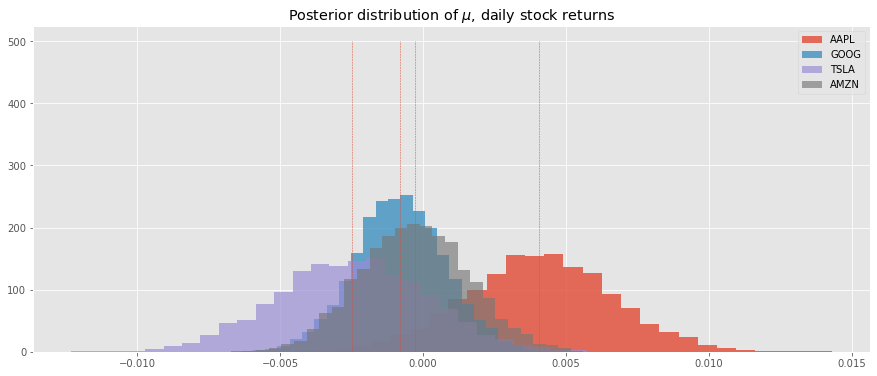

In [21]:
figsize(15,6)

#examine the mean return first.
mu_samples = trace.posterior.returns.data[0]

for i in range(4):
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", density=True, 
             label = "%s" % stock_returns.columns[i])

plt.vlines(mu_samples.mean(axis=0), 0, 500, linestyle="--", linewidth = .5)

plt.title("Posterior distribution of $\mu$, daily stock returns")
plt.legend();

(Plots like these are what inspired the book's cover.)

What can we say about the results above? Clearly TSLA has been a strong performer, and our analysis suggests that it has an almost 1% daily return! Similarly, most of the distribution of AAPL is negative, suggesting that its *true daily return* is negative.


You may not have immediately noticed, but these variables are a whole order of magnitude *less* than our priors on them. For example, to put these one the same scale as the above prior distributions:

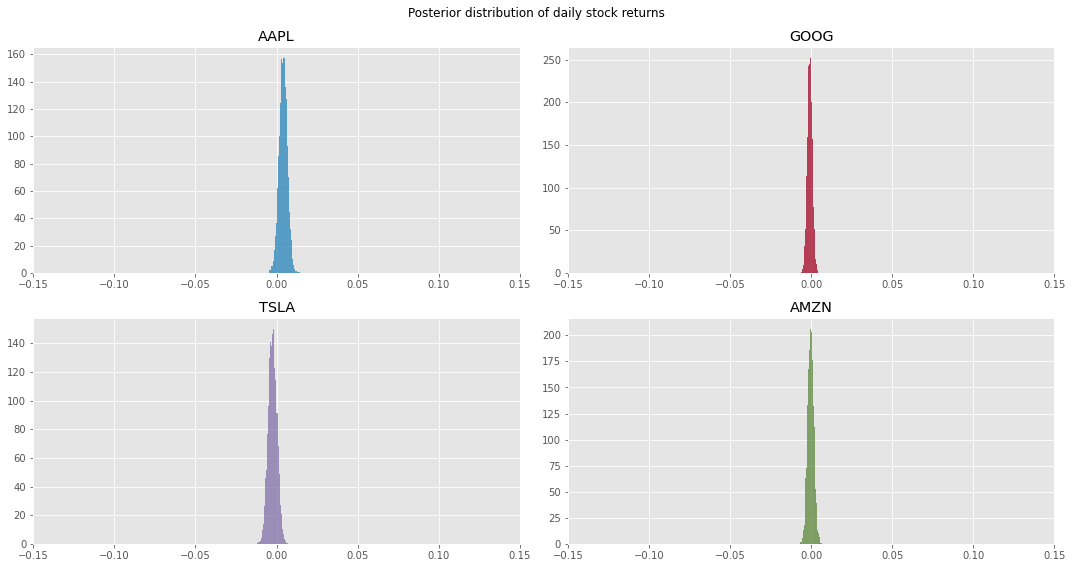

In [22]:
figsize(15.0,8)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", density=True, color = colors[i],
             label = "%s" % stock_returns.columns[i])
    plt.title("%s" % stock_returns.columns[i])
    plt.xlim(-0.15, 0.15)
    
plt.suptitle("Posterior distribution of daily stock returns")
plt.tight_layout()

Why did this occur? Recall how I mentioned that finance has a very very low signal to noise ratio. This implies an environment where inference is much more difficult. One should be careful about over-interpreting these results: notice (in the first figure) that each distribution is positive at 0, implying that the stock may return nothing. Furthermore, the subjective priors influenced the results. From the fund managers point of view, this is good as it reflects his updated beliefs about the stocks, whereas from a neutral viewpoint this can be too subjective of a result.  

Below we show the posterior correlation matrix, and posterior standard deviations. An important caveat to know is that the Wishart distribution models the *inverse covariance matrix*, so we must invert it to get the covariance matrix. We also normalize the matrix to acquire the *correlation matrix*. Since we cannot plot hundreds of matrices effectively, we settle by summarizing the posterior distribution of correlation matrices by showing the *mean posterior correlation matrix* (defined on line 2).

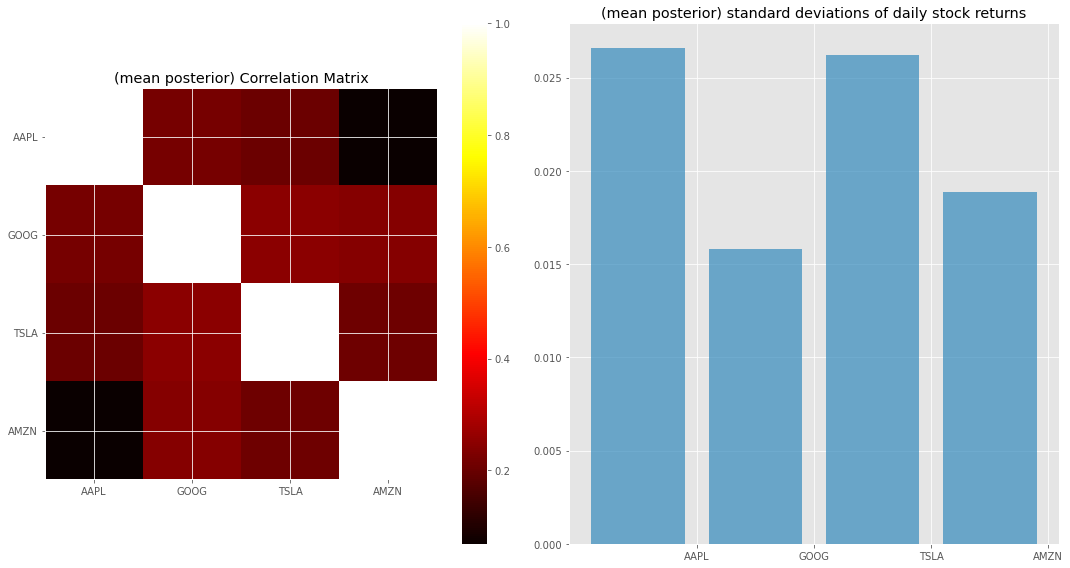

In [23]:
cov_samples = trace.posterior.covariance.data[0]
mean_covariance_matrix = cov_samples.mean(axis=0)

def cov2corr(A):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    #A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A


plt.subplot(1,2,1)
plt.imshow(cov2corr(mean_covariance_matrix) , interpolation="none", 
                cmap = "hot") 
plt.xticks(np.arange(4), stock_returns.columns)
plt.yticks(np.arange(4), stock_returns.columns)
plt.colorbar(orientation="vertical")
plt.title("(mean posterior) Correlation Matrix")

plt.subplot(1,2,2)
plt.bar(np.arange(4), np.sqrt(np.diag(mean_covariance_matrix)),
        color = "#348ABD", alpha = 0.7)
plt.xticks(np.arange(4) + 0.5, stock_returns.columns);
plt.title("(mean posterior) standard deviations of daily stock returns")

plt.tight_layout();


Looking at the above figures, we can say that likely TSLA has an above-average volatility (looking at the return graph this is quite clear). The correlation matrix shows that there are not strong correlations present, but perhaps GOOG and AMZN express a higher correlation (about 0.30).  

With this Bayesian analysis of the stock market, we can throw it into a Mean-Variance optimizer (which I cannot stress enough, do not use with frequentist point estimates) and find the minimum. This optimizer balances the tradeoff between a high return and high variance.

$$ w_{opt} = \max_{w} \frac{1}{N}\left( \sum_{i=0}^N \mu_i^T w - \frac{\lambda}{2}w^T\Sigma_i w \right)$$

where $\mu_i$ and $\Sigma_i$ are the $i$th posterior estimate of the mean returns and the covariance matrix. This is another example of loss function optimization.

### Protips for the Wishart distribution

If you plan to be using the Wishart distribution, read on. Else, feel free to skip this. 

In the problem above, the Wishart distribution behaves pretty nicely. Unfortunately, this is rarely the case. The problem is that estimating an $NxN$ covariance matrix involves estimating $\frac{1}{2}N(N-1)$ unknowns. This is a large number even for modest $N$. Personally, I've tried performing a similar simulation as above with $N = 23$ stocks, and ended up giving considering that I was requesting my MCMC simulation to estimate at least $\frac{1}{2}23*22 = 253$ additional unknowns (plus the other interesting unknowns in the problem). This is not easy for MCMC. Essentially, you are asking you MCMC to traverse 250+ dimensional space. And the problem seemed so innocent initially! Below are some tips, in order of supremacy:

1. Use conjugancy if it applies. See section below.

2. Use a good starting value. What might be a good starting value? Why, the data's sample covariance matrix is! Note that this is not empirical Bayes: we are not touching the prior's parameters, we are modifying the starting value of the MCMC. Due to numerical instability, it is best to truncate the floats in the sample covariance matrix down a few degrees of precision (e.g. instability can cause unsymmetrical matrices, which can cause PyMC3 to cry.). 

3. Provide as much domain knowledge in the form of priors, if possible. I stress *if possible*. It is likely impossible to have an estimate about each $\frac{1}{2}N(N-1)$ unknown. In this case, see number 4.

4. Use empirical Bayes, i.e. use the sample covariance matrix as the prior's parameter.

5. For problems where $N$ is very large, nothing is going to help. Instead, ask, do I really care about *every* correlation? Probably not. Further ask yourself, do I really really care about correlations? Possibly not. In finance, we can set an informal hierarchy of what we might be interested in the most: first a good estimate of $\mu$, the variances along the diagonal of the covariance matrix are secondly important, and finally the correlations are least important. So, it might be better to ignore the $\frac{1}{2}(N-1)(N-2)$ correlations and instead focus on the more important unknowns.

**Another thing** to note is that the implementation of the Wishart distribution has changed in from PyMC to PyMC3. Wishart distribution matrices are required to have certain mathematical characteristics that are very restrictive. This makes it so that it is impossible for MCMC methods to propose matrices that will be accepted in our sampling procedure. With our model here we sample the Bartlett decomposition of a Wishart distribution matrix and use that to calculate our samples for the covariance matrix (http://en.wikipedia.org/wiki/Wishart_distribution#Bartlett_decomposition).

## Conjugate Priors

Recall that a $\text{Beta}$ prior with $\text{Binomial}$ data implies a $\text{Beta}$ posterior. Graphically:

$$ \underbrace{\text{Beta}}_{\text{prior}} \cdot \overbrace{\text{Binomial}}^{\text{data}} = \overbrace{\text{Beta}}^{\text{posterior} } $$ 

Notice the $\text{Beta}$ on both sides of this equation (no, you cannot cancel them, this is not a *real* equation). This is a really useful property. It allows us to avoid using MCMC, since the posterior is known in closed form. Hence inference and analytics are easy to derive. This shortcut was the heart of the  Bayesian Bandit algorithm above. Fortunately, there is an entire family of distributions that have similar behaviour.  

Suppose $X$ comes from, or is believed to come from, a well-known distribution, call it $f_{\alpha}$, where $\alpha$ are possibly unknown parameters of $f$. $f$ could be a Normal distribution, or Binomial distribution, etc. For particular distributions $f_{\alpha}$, there may exist a prior distribution $p_{\beta}$, such that:

$$ \overbrace{p_{\beta}}^{\text{prior}} \cdot \overbrace{f_{\alpha}(X)}^{\text{data}} = \overbrace{p_{\beta'}}^{\text{posterior} } $$ 

where $\beta'$ is a different set of parameters *but $p$ is the same distribution as the prior*. A prior $p$ that satisfies this relationship is called a *conjugate prior*. As I mentioned, they are useful computationally, as we can avoided approximate inference using MCMC and go directly to the posterior. This sounds great, right?

Unfortunately, not quite. There are a few issues with conjugate priors.

1. The conjugate prior is not objective. Hence only useful when a subjective prior is required. It is not guaranteed that the conjugate prior can accommodate the practitioner's subjective opinion.

2. There typically exist conjugate priors for simple, one dimensional problems. For larger problems, involving more complicated structures, hope is lost to find a conjugate prior. For smaller models, Wikipedia has a nice [table of conjugate priors](http://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).

Really, conjugate priors are only useful for their mathematical convenience: it is simple to go from prior to posterior. I personally see conjugate priors as only a neat mathematical trick, and offer little insight into the problem at hand. 

## Jefferys Priors

Earlier, we talked about objective priors rarely being *objective*. Partly what we mean by this is that we want a prior that doesn't bias our posterior estimates. The flat prior seems like a reasonable choice as it assigns equal probability to all values. 

But the flat prior is not transformation invariant. What does this mean? Suppose we have a random variable $\textbf X$ from Bernoulli($\theta$). We define the prior on $p(\theta) = 1$. 

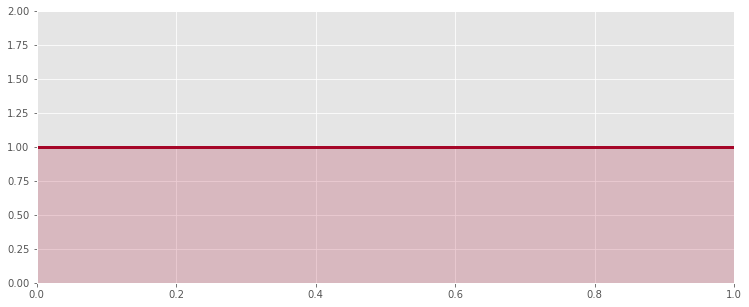

In [24]:
figsize(12.5, 5)

x = np.linspace(0.000 ,1, 150)
y = np.linspace(1.0, 1.0, 150)
lines = plt.plot(x, y, color="#A60628", lw = 3)
plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
plt.autoscale(tight=True)
plt.ylim(0, 2);

Now, let's transform $\theta$ with the function $\psi = log \frac{\theta}{1-\theta}$. This is just a function to stretch $\theta$ across the real line. Now how likely are different values of $\psi$ under our transformation.

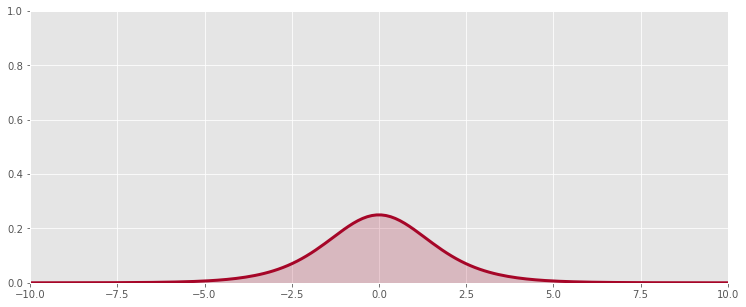

In [25]:
figsize(12.5, 5)

psi = np.linspace(-10 ,10, 150)
y = np.exp(psi) / (1 + np.exp(psi))**2
lines = plt.plot(psi, y, color="#A60628", lw = 3)
plt.fill_between(psi, 0, y, alpha = 0.2, color = lines[0].get_color())
plt.autoscale(tight=True)
plt.ylim(0, 1);

Oh no! Our function is no longer flat. It turns out flat priors do carry information in them after all. The point of Jeffreys Priors is to create priors that don't accidentally become informative when you transform the variables you placed them originally on.

Jeffreys Priors are defined as:

$$p_J(\theta) \propto \mathbf{I}(\theta)^\frac{1}{2}$$
$$\mathbf{I}(\theta) = - \mathbb{E}\bigg[\frac{d^2 \text{ log } p(X|\theta)}{d\theta^2}\bigg]$$

$\mathbf{I}$ being the *Fisher information*

## Effect of the prior as $N$ increases

In the first chapter, I proposed that as the amount of our observations or data increases, the influence of the prior decreases. This is intuitive. After all, our prior is based on previous information, and eventually enough new information will shadow our previous information's value. The smothering of the prior by enough data is also helpful: if our prior is significantly wrong, then the self-correcting nature of the data will present to us a *less wrong*, and eventually *correct*, posterior. 

We can see this mathematically. First, recall Bayes Theorem from Chapter 1 that relates the prior to the posterior. The following is a sample from [What is the relationship between sample size and the influence of prior on posterior?](http://stats.stackexchange.com/questions/30387/what-is-the-relationship-between-sample-size-and-the-influence-of-prior-on-poste)[1] on CrossValidated.

>The posterior distribution for a parameter $\theta$, given a data set ${\textbf X}$ can be written as 

$$p(\theta | {\textbf X}) \propto \underbrace{p({\textbf X} | \theta)}_{{\textrm likelihood}}  \cdot  \overbrace{ p(\theta) }^{ {\textrm prior} }  $$



>or, as is more commonly displayed on the log scale, 

$$ \log( p(\theta | {\textbf X})  ) = c + L(\theta;{\textbf X}) + \log(p(\theta)) $$

>The log-likelihood, $L(\theta;{\textbf X}) = \log \left( p({\textbf X}|\theta) \right)$, **scales with the sample size**, since it is a function of the data, while the prior density does not. Therefore, as the sample size increases, the absolute value of $L(\theta;{\textbf X})$ is getting larger while $\log(p(\theta))$ stays fixed (for a fixed value of $\theta$), thus the sum $L(\theta;{\textbf X}) + \log(p(\theta))$ becomes more heavily influenced by $L(\theta;{\textbf X})$ as the sample size increases. 

There is an interesting consequence not immediately apparent. As the sample size increases, the chosen prior has less influence. Hence inference converges regardless of chosen prior, so long as the areas of non-zero probabilities are the same. 

Below we visualize this. We examine the convergence of two posteriors of a Binomial's parameter $\theta$, one with a flat prior and the other with a biased prior towards 0. As the sample size increases, the posteriors, and hence the inference, converge.

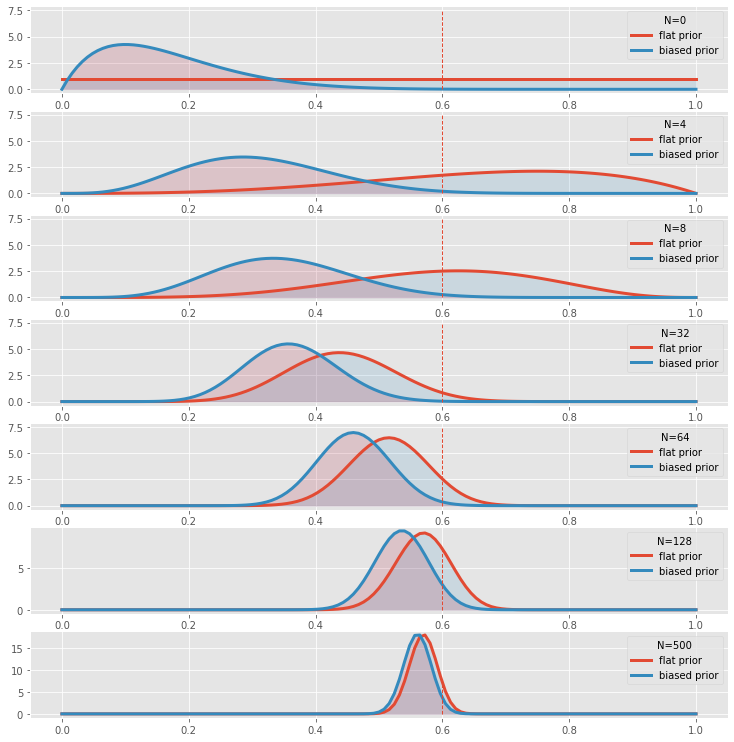

In [26]:
figsize(12.5, 15)

p = 0.6
beta1_params = np.array([1.,1.])
beta2_params = np.array([2,10])
beta = stats.beta

x = np.linspace(0.00, 1, 125)
data = stats.bernoulli.rvs(p, size=500)

plt.figure()
for i,N in enumerate([0,4,8, 32,64, 128, 500]):
    s = data[:N].sum() 
    plt.subplot(8,1,i+1)
    params1 = beta1_params + np.array([s, N-s])
    params2 = beta2_params + np.array([s, N-s])
    y1,y2 = beta.pdf(x, *params1), beta.pdf( x, *params2)
    plt.plot(x,y1, label = r"flat prior", lw =3)
    plt.plot(x, y2, label = "biased prior", lw= 3)
    plt.fill_between(x, 0, y1, color ="#348ABD", alpha = 0.15) 
    plt.fill_between(x, 0, y2, color ="#A60628", alpha = 0.15) 
    plt.legend(title = "N=%d" % N)
    plt.vlines(p, 0.0, 7.5, linestyles = "--", linewidth=1)
    #plt.ylim( 0, 10)#


Keep in mind, not all posteriors will "forget" the prior this quickly. This example was just to show that *eventually* the prior is forgotten. The "forgetfulness" of the prior as we become awash in more and more data is the reason why Bayesian and Frequentist inference eventually converge as well.

### Bayesian perspective of Penalized Linear Regressions

There is a very interesting relationship between a penalized least-squares regression and Bayesian priors. A penalized linear regression is a optimization problem of the form:

$$ \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta)  + f(\beta)$$

for some function $f$ (typically a norm like $|| \cdot ||_p^p$). 

We will first describe the probabilistic interpretation of least-squares linear regression. Denote our response variable $Y$, and features are contained in the data matrix $X$. The standard linear model is:

\begin{equation}
Y = X\beta + \epsilon
\end{equation}

where $\epsilon \sim \text{Normal}( {\textbf 0}, \sigma{\textbf I })$. Simply, the observed $Y$ is a linear function of $X$ (with coefficients $\beta$) plus some noise term. Our unknown to be determined is $\beta$. We use the following property of Normal random variables:

$$ \mu' + \text{Normal}( \mu, \sigma ) \sim \text{Normal}( \mu' + \mu , \sigma ) $$

to rewrite the above linear model as:

\begin{align}
& Y = X\beta + \text{Normal}( {\textbf 0}, \sigma{\textbf I }) \\\\
& Y = \text{Normal}( X\beta , \sigma{\textbf I }) \\\\
\end{align}

In probabilistic notation, denote $f_Y(y \; | \; \beta )$ the probability distribution of $Y$, and recalling the density function for a Normal random variable (see [here](http://en.wikipedia.org/wiki/Normal_distribution) ):

$$ f_Y( Y \; |\; \beta, X) = L(\beta|\; X,Y)= \frac{1}{\sqrt{ 2\pi\sigma} } \exp \left( \frac{1}{2\sigma^2} (Y - X\beta)^T(Y - X\beta) \right) $$

This is the likelihood function for $\beta$. Taking the $\log$:

$$ \ell(\beta) = K - c(Y - X\beta)^T(Y - X\beta) $$

where $K$ and $c>0$ are constants. Maximum likelihood techniques wish to maximize this for $\beta$, 

$$\hat{ \beta } = \text{argmax}_{\beta} \;\; - (Y - X\beta)^T(Y - X\beta) $$

Equivalently we can *minimize the negative* of the above:

$$\hat{ \beta } = \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta) $$

This is the familiar least-squares linear regression equation. Therefore we showed that the solution to a linear least-squares is the same as the maximum likelihood assuming Normal noise. Next we extend this to show how we can arrive at penalized linear regression by a suitable choice of prior on $\beta$. 

#### Penalized least-squares

In the above, once we have the likelihood, we can include a prior distribution on $\beta$ to derive to the equation for the posterior distribution:

$$P( \beta | Y, X ) = L(\beta|\;X,Y)p( \beta )$$

where $p(\beta)$ is a prior on the elements of $\beta$. What are some interesting priors? 

1\. If we include *no explicit* prior term, we are actually including an uninformative prior, $P( \beta ) \propto 1$, think of it as uniform over all numbers. 

2\. If we have reason to believe the elements of $\beta$ are not too large, we can suppose that *a priori*:

$$ \beta \sim \text{Normal}({\textbf 0 }, \lambda {\textbf I } ) $$

The resulting posterior density function for $\beta$ is *proportional to*:

$$ \exp \left( \frac{1}{2\sigma^2} (Y - X\beta)^T(Y - X\beta) \right) \exp \left( \frac{1}{2\lambda^2} \beta^T\beta \right) $$

and taking the $\log$ of this, and combining and redefining constants, we arrive at:

$$ \ell(\beta) \propto K -  (Y - X\beta)^T(Y - X\beta) - \alpha \beta^T\beta  $$

we arrive at the function we wish to maximize (recall the point that maximizes the posterior distribution is the MAP, or *maximum a posterior*):

$$\hat{ \beta } = \text{argmax}_{\beta} \;\; -(Y - X\beta)^T(Y - X\beta) - \alpha \;\beta^T\beta $$

Equivalently, we can minimize the negative of the above, and rewriting $\beta^T \beta = ||\beta||_2^2$:

$$\hat{ \beta } = \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta) + \alpha \;||\beta||_2^2$$

This above term is exactly Ridge Regression. Thus we can see that ridge regression corresponds to the MAP of a linear model with Normal errors and a Normal prior on $\beta$.

3\. Similarly, if we assume a *Laplace* prior on $\beta$, ie. 

$$ f_\beta( \beta) \propto \exp \left(- \lambda ||\beta||_1 \right)$$

and following the same steps as above, we recover:

$$\hat{ \beta } = \text{argmin}_{\beta} \;\; (Y - X\beta)^T(Y - X\beta) + \alpha \;||\beta||_1$$

which is LASSO regression. Some important notes about this equivalence. The sparsity that is a result of using a LASSO regularization is not a result of the prior assigning high probability to sparsity. Quite the opposite actually. It is the combination of the $|| \cdot ||_1$ function and using the MAP that creates sparsity on $\beta$: [purely a geometric argument](http://camdp.com/blogs/least-squares-regression-l1-penalty). The prior does contribute to an overall shrinking of the coefficients towards 0 though. An interesting discussion of this can be found in [2].

For an example of Bayesian linear regression, see Chapter 4's example on financial losses.

##### References

1. Macro, . "What is the relationship between sample size and the influence of prior on posterior?." 13 Jun 2013. StackOverflow, Online Posting to Cross-Validated. Web. 25 Apr. 2013.

2. Starck, J.-L., , et al. "Sparsity and the Bayesian Perspective." Astronomy & Astrophysics. (2013): n. page. Print.

3. Kuleshov, Volodymyr, and Doina Precup. "Algorithms for the multi-armed bandit problem." Journal of Machine Learning Research. (2000): 1-49. Print.

4. Gelman, Andrew. "Prior distributions for variance parameters in hierarchical models." Bayesian Analysis. 1.3 (2006): 515-533. Print.

5. Gelman, Andrew, and Cosma R. Shalizi. "Philosophy and the practice of Bayesian statistics." British Journal of Mathematical and Statistical Psychology. (2012): n. page. Web. 17 Apr. 2013.

6. http://jmlr.csail.mit.edu/proceedings/papers/v22/kaufmann12/kaufmann12.pdf

7. James, Neufeld. "Reddit's "best" comment scoring algorithm as a multi-armed bandit task." Simple ML Hacks. Blogger, 09 Apr 2013. Web. 25 Apr. 2013.

8. Oakley, J. E., Daneshkhah, A. and O’Hagan, A. Nonparametric elicitation using the roulette method. Submitted to Bayesian Analysis.

9. "Eliciting priors from experts." 19 Jul 2010. StackOverflow, Online Posting to Cross-Validated. Web. 1 May. 2013. <http://stats.stackexchange.com/questions/1/eliciting-priors-from-experts>.

10. Taleb, Nassim Nicholas (2007), The Black Swan: The Impact of the Highly Improbable, Random House, ISBN 978-1400063512

In [27]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()